# 初期設定

## ライブラリ

In [ ]:
!pip install --target /content/drive/MyDrive/Colab\ Notebooks/module catboost

In [6]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/module')

In [8]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoost
from catboost import Pool
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: ignored

## データ

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/train_preprocessed.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/test_preprocessed.csv')
test_x.head()

,age,sex,height,weight,product,amount,medical_info_a1,medical_info_a2,medical_info_a3,medical_info_b1,medical_info_b2,medical_info_b3,medical_info_c1,medical_info_c2,medical_keyword_1,medical_keyword_2,medical_keyword_3,medical_keyword_4,medical_keyword_5,medical_keyword_6,medical_keyword_7,medical_keyword_8,medical_keyword_9,medical_keyword_10,year,month,day,yearmonth
0,49,1,187.431987,81.008363,1,1000000,302,212,1,10,1,8,3.0,NaN,1,1,0,1,0,1,0,1,0,0,2016,12,6,24204
1,79,1,171.632630,71.067812,6,2000,197,469,0,14,0,4,3.0,NaN,0,1,0,0,0,0,0,0,1,1,2016,9,3,24201
2,78,0,163.543983,64.032098,0,4000000,247,225,2,17,0,16,NaN,NaN,1,0,0,0,0,1,0,1,0,0,2015,4,10,24184
3,26,1,150.391858,52.322910,2,1000000,108,228,0,15,1,1,0.0,NaN,1,0,0,0,0,0,1,0,0,0,2016,4,17,24196
4,14,1,165.835167,67.008154,2,4000000,181,90,2,11,0,10,0.0,NaN,1,1,0,0,0,0,0,1,0,0,2015,1,26,24181


In [ ]:
train_y.head()

0    0
1    0
2    1
3    0
4    1
Name: target, dtype: int64

# モデルとは？

## KFoldの検証

In [ ]:
# 学習データ・バリデーションデータを分けるためのインデックスを作成する
# 学習データを4つに分割し、うち1つをバリデーションデータとする
kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
print(type(tr_idx))
print(tr_idx[:5])
print(list(kf.split(train_x))[0])

# 学習データを学習データとバリデーションデータに分ける
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

<class 'numpy.ndarray'>
[0 1 2 3 4]
(array([   0,    1,    2, ..., 9996, 9998, 9999]), array([   6,   10,   11, ..., 9994, 9995, 9997]))


## CVコード例

In [ ]:
train_x.head()

,age,sex,height,weight,product,amount,medical_info_a1,medical_info_a2,medical_info_a3,medical_info_b1,medical_info_b2,medical_info_b3,medical_info_c1,medical_info_c2,medical_keyword_1,medical_keyword_2,medical_keyword_3,medical_keyword_4,medical_keyword_5,medical_keyword_6,medical_keyword_7,medical_keyword_8,medical_keyword_9,medical_keyword_10,year,month,day,yearmonth
0,50,1,166.445608,65.016732,9,7000000,134,202,1,11,2,1,1.0,NaN,1,0,0,0,0,1,0,1,0,0,2015,2,3,24182
1,68,0,164.334615,56.544217,0,7000000,438,263,3,14,1,7,NaN,NaN,0,0,0,0,0,0,1,1,0,0,2015,5,9,24185
2,77,1,167.462917,54.242267,2,6000000,313,325,1,18,3,11,2.0,NaN,1,1,1,0,0,1,0,1,0,0,2016,2,13,24194
3,17,1,177.097725,71.147762,3,8000000,342,213,2,11,0,9,2.0,16.167065,1,0,0,0,0,0,0,1,0,0,2015,7,6,24187
4,62,0,158.165788,65.240697,1,9000000,327,102,0,14,0,9,2.0,NaN,0,1,1,0,0,0,1,1,1,0,2016,9,17,24201


In [ ]:
# -----------------------------------
# クロスバリデーション
# -----------------------------------
# 学習データを4つに分け、うち1つをバリデーションデータとする
# どれをバリデーションデータとするかを変えて学習・評価を4回行う
scores = []
kf = KFold(n_splits=4, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(train_x):
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]
    model = lgb.LGBMClassifier()
    model.fit(tr_x, tr_y)
    va_pred = model.predict(va_x)
    score = log_loss(va_y, va_pred)
    scores.append(score)
print(scores)

# クロスバリデーションの平均のスコアを出力する
print(f'logloss: {np.mean(scores):.4f}')

[3.3157420440887226, 3.0670634937233103, 3.2466641714599294, 3.5506073227689763]
logloss: 3.2950


## GBDT
- 決定木を逐次的に繰り返すことで精度を高めるロジック
- １つ目は予想値に対して、２つ目以降は残差に対して目的関数を最小化していく

### XGboost

In [ ]:
# -----------------------------------
# xgboostの実装
# -----------------------------------

# 学習データを学習データとバリデーションデータに分ける
scores = []
models = []
# training data の target と同じだけのゼロ配列を用意
oof_pred = np.zeros_like(train_y, dtype=np.float)

# ハイパーパラメータの設定
# 目的変数を追加
#  モニタリングをloglossで行い、アーリーストッピングの観察するroundを20とする
params = {'objective': 'binary:logistic',
          'silent': 1,
          'random_state': 71,
          'eval_metric': 'logloss'
          }
num_round = 500

kf = KFold(n_splits=4, shuffle=True, random_state=71)

#cv, enumerateを追加
for i, (tr_idx, va_idx) in enumerate(kf.split(train_x), 1):
  tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
  tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

  # 特徴量と目的変数をxgboostのデータ構造に変換する
  dtrain = xgb.DMatrix(tr_x, label=tr_y)
  dvalid = xgb.DMatrix(va_x, label=va_y)
#  dtest = xgb.DMatrix(test_x)

  # 学習の実行
  # バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
  # watchlistには学習データおよびバリデーションデータをセットする
  watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
  print('fold', i)

  # early_stopping_roundsの設定回数は必ずやった上でその後stopがかかる　（実測73後）
  model = xgb.train(params, dtrain, num_round, evals=watchlist, early_stopping_rounds=20)

  # バリデーションデータでのスコアの確認
  # early_stoppingした# 最適な決定木の本数で予測を行う ntree_limit=model.best_ntree_limitを追加
  va_pred = model.predict(dvalid, ntree_limit=model.best_ntree_limit)

  # early_stoppingを設定するのであればloglossが出てくるので以下のコードは不要になる
  oof_pred[va_idx] = va_pred
  score = log_loss(va_y, va_pred)
  print(f'Fold {i} logloss: {score:.4f}')

  scores.append(score)
  models.append(model)

print(type(oof_pred))
wh_score = log_loss(train_y, oof_pred)

print('scores', scores)
print(f'Whole logloss1: {np.mean(scores):.4f}')
print(f'Whole logloss2: {wh_score}')


# 予測（二値の予測値ではなく、1である確率を出力するようにしている）
# cv毎に作成したmodelで推論　推論値を平均
dtest = xgb.DMatrix(test_x)
pred = np.array([model.predict(dtest, ntree_limit=model.best_ntree_limit) for model in models])
pred_mean = np.mean(pred, axis=0)
print(pred.shape)
print(pred_mean.shape)
print(pred_mean)

fold 1
[0]	train-logloss:0.540885	eval-logloss:0.550036
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 20 rounds.
[1]	train-logloss:0.452701	eval-logloss:0.471819
[2]	train-logloss:0.394822	eval-logloss:0.42026
[3]	train-logloss:0.351981	eval-logloss:0.385204
[4]	train-logloss:0.320214	eval-logloss:0.361497
[5]	train-logloss:0.296731	eval-logloss:0.344632
[6]	train-logloss:0.276105	eval-logloss:0.329004
[7]	train-logloss:0.258859	eval-logloss:0.316697
[8]	train-logloss:0.243629	eval-logloss:0.30775
[9]	train-logloss:0.231528	eval-logloss:0.300926
[10]	train-logloss:0.220163	eval-logloss:0.294131
[11]	train-logloss:0.209624	eval-logloss:0.285281
[12]	train-logloss:0.199507	eval-logloss:0.279123
[13]	train-logloss:0.193238	eval-logloss:0.276415
[14]	train-logloss:0.185473	eval-logloss:0.271543
[15]	train-logloss:0.174737	eval-logloss:0.265163
[16]	train-logloss:0.168997	eval-logloss:0.260891
[17]	t

### LightGBM
xgboostとの違い
- 決定木の分岐が数値ベースではなくヒストグラムベース ⇨ 高速化
  - ヒストグラムを作って数値を一定のまとまりにわけ、そのまとまりで分岐をする　⇨ クラスタリングによる分岐をしている？？
- 深さ単位ではなく葉単位　⇨ 高速化
- カテゴリ変数の分割の最適化　⇨ 精度向上
  - カテゴリ変数をパラメータで指定することでそれぞれの分岐で勾配や二階微分値を見て最適な２つの集合に分けてくれる

In [ ]:
# -----------------------------------
# lightgbmの実装
# -----------------------------------

# それぞれ格納するリストを作成
scores = []
models = []

# training data の target と同じだけのゼロ配列を用意
oof_pred = np.zeros_like(train_y, dtype=np.float)

# 学習データを学習データとバリデーションデータに分ける
kf = KFold(n_splits=4, shuffle=True, random_state=71)

# ハイパーパラメータの設定
params = {'objective': 'binary',
           'metrics': 'binary_logloss',
           'random_state': 71
           }

num_round = 1000

# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
categorical_features = ['product', 'medical_info_b2', 'medical_info_b3']

# UserWarning対策
# https://titanwolf.org/Network/Articles/Article?AID=c676071a-ff7d-4c5a-a896-9381f02be3a6
# train_x[categorical_features] = train_x[categorical_features].astype('category')
# test_x[categorical_features] = test_x[categorical_features].astype('category')

#cv, enumerateを追加
for i, (tr_idx, va_idx) in enumerate(kf.split(train_x), 1):
  tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
  tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

  # 特徴量と目的変数をlightgbmのデータ構造に変換する
  lgb_train = lgb.Dataset(tr_x, tr_y, categorical_feature=categorical_features)
  lgb_eval = lgb.Dataset(va_x, va_y, categorical_feature=categorical_features)

  # 学習の実行
  # カテゴリ変数をパラメータで指定している
  model = lgb.train(params, lgb_train, num_boost_round=num_round,
                    categorical_feature=categorical_features,
                    early_stopping_rounds=100,
                    valid_names=['train', 'valid'], valid_sets=[lgb_train, lgb_eval],
                    verbose_eval=50)

  # バリデーションデータでのスコアの確認
  va_pred = model.predict(va_x)
  # 推論値を格納
  oof_pred[va_idx] = va_pred
  score = log_loss(va_y, va_pred)

  print(f'Fold {i} logloss: {score:.4f}')
  scores.append(score)
  models.append(model)

# 全体でのlog lossスコアを算出
wh_score = log_loss(train_y, oof_pred)
print('scores', scores)
print(f'Whole logloss1: {np.mean(scores):.4f}')
print(f'Whole logloss2: {wh_score}')

# 予測（二値の予測値ではなく、1である確率を出力するようにしている）
# cv毎に作成したmodelで推論　推論値を平均
pred = np.array([model.predict(test_x) for model in models])
pred_mean = np.mean(pred, axis=0)
print('pred', pred.shape)
print('pred_mean', pred_mean.shape)
print('pred', pred)
print('pred_mean', pred_mean)

### catboost
- カテゴリ変数のtarget encodingを行なって分岐をしている
- 同的にカテゴリ変数の組み合わせに対してtarget encodingが行われる
  - ある分岐でカテゴリ変数が使われたとき、そのカテゴリ変数と他のカテゴリ変数との組み合わせに対してtarget encodingの計算が行わレ、それより深い分岐においてはその結果が利用される

In [ ]:
# 32min
# 本には載っていなかったがコーディングを自分で行ってみる
# -----------------------------------
# catboostの実装
# -----------------------------------

# それぞれ格納するリストを作成
scores = []
models = []

# training data の target と同じだけのゼロ配列を用意
oof_pred = np.zeros_like(train_y, dtype=np.float)

# 学習データを学習データとバリデーションデータに分ける
kf = KFold(n_splits=4, shuffle=True, random_state=71)

# ハイパーパラメータの設定
params = {
     "loss_function": "RMSE",
     "random_state" : 0,
     "learning_rate" : 0.1,
     "num_boost_round" : 1000000,
     "early_stopping_rounds" : 100,
     "verbose_eval" : 100
    }


# バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
categorical_features = ['product', 'medical_info_b2', 'medical_info_b3']

#cv, enumerateを追加
for i, (tr_idx, va_idx) in enumerate(kf.split(train_x), 1):
  tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
  tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

  # 特徴量と目的変数をlightgbmのデータ構造に変換する
  cat_train = Pool(train_x, train_y, cat_features=categorical_features)
  cat_valid = Pool(train_x, train_y, cat_features=categorical_features)

  # 学習の実行
  # カテゴリ変数をパラメータで指定している
  model = CatBoost(params)
  model.fit(cat_train,
            eval_set=cat_valid,
            early_stopping_rounds=10,
            use_best_model=True,
            plot=True
            )

  # バリデーションデータでのスコアの確認
  va_pred = model.predict(va_x)
  # 推論値を格納
  oof_pred[va_idx] = va_pred
  score = log_loss(va_y, va_pred)

  print(f'Fold {i} logloss: {score:.4f}')
  scores.append(score)
  models.append(model)

# 全体でのlog lossスコアを算出
wh_score = log_loss(train_y, oof_pred)
print('scores', scores)
print(f'Whole logloss1: {np.mean(scores):.4f}')
print(f'Whole logloss2: {wh_score}')

# 予測（二値の予測値ではなく、1である確率を出力するようにしている）
# cv毎に作成したmodelで推論　推論値を平均
pred = np.array([model.predict(test_x) for model in models])
pred_mean = np.mean(pred, axis=0)
print('pred', pred.shape)
print('pred_mean', pred_mean.shape)
print('pred', pred)
print('pred_mean', pred_mean)

## ニューラルネット
- 特徴量は数値
- 欠損値を扱うことができない
- **非線形性や変数間の相互作用が反映される**
- 特徴量は標準化する必要がある（スケールを合わしておく）
- ハイパーパラメータの調整が難しい
- 他クラス分類に比較的強い
  - GBDTと遜色ない能力を出せる
- コーディングに手間がかかる
- 主なライブラリ
  - keras | tensorflowなどのライブラリをバックエンドとして持っているラッパー 
  - pytorch
  - chainer
  - tensorflow

In [ ]:
# tensorflowの警告抑制
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# -----------------------------------
# ニューラルネットの実装
# -----------------------------------
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

# それぞれ格納するリストを作成
scores = []
models = []

# training data の target と同じだけのゼロ配列を用意
oof_pred = np.zeros_like(train_y, dtype=np.float)

#cv, enumerateを追加
for i, (tr_idx, va_idx) in enumerate(kf.split(train_x), 1):
  tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
  tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

  # データのスケーリング
  scaler = StandardScaler()
  tr_x = scaler.fit_transform(tr_x)
  va_x = scaler.transform(va_x)
  test_x = scaler.transform(test_x)

  # https://keras.io/ja/getting-started/sequential-model-guide/
  # ニューラルネットモデルの構築
  model = Sequential()
  # addでレイヤーを積み重ねる
  #レイヤー種類
  # embedding layer | 正の整数を密な数値ベクトルに変換する層 最初のレイヤとしてのみ利用可能 カテゴリ変数（label encordingしたもの）を入力する時に利用することができる
   # https://keras.io/ja/layers/embeddings/
   # https://tksmml.hatenablog.com/entry/2019/09/01/112900
   # embeddingはここでは使用していない
  #batch normalization | 各バッチ毎に前の層の出力を正規化する（平均0, 標準偏差1）
   # https://keras.io/ja/layers/normalization/

  model.add(Dense(256, activation='relu', input_shape=(train_x.shape[1],)))
  # ドロップアウト | ユニットのうち何割をドロップするかの割合
  model.add(Dropout(0.2))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))

  # 二値分類 | loss='binary_crossentropy'　 logloss
  # 回帰 | loss = 'mean_square_error'  平均二乗誤差
  # マルチクラス分類 | loss = 'categorical_crossentropy'  multi-class logloss
  # optimizer | adam, rmsprop, adagradなど
  model.compile(loss='binary_crossentropy',
                optimizer='adam', metrics=['accuracy'])

  # 学習の実行
  # バリデーションデータもモデルに渡し、学習の進行とともにスコアがどう変わるかモニタリングする
  # ミニバッチ | 少数のサンプルに分けた学習データ batch_sizeはミニバッチのサイズだと推察
  batch_size = 128

  # -----------------------------------
  # アーリーストッピング
  # -----------------------------------

  # アーリーストッピングの観察するroundを20とする
  # epoch | 学習回数 ニューラルネットで最後まで学習した回数
  # restore_best_weightsを設定することで、最適なエポックでのモデルを使用する
  epochs = 50
  early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

  history = model.fit(tr_x, tr_y,
                      batch_size=batch_size, epochs=epochs,
                      verbose=1, validation_data=(va_x, va_y), callbacks=[early_stopping])


  # バリデーションデータでのスコアの確認
  va_pred = model.predict(va_x)
  # 推論値を格納
  oof_pred[va_idx] = va_pred[:, 0]
  score = log_loss(va_y, va_pred)

  print(f'Fold {i} logloss: {score:.4f}')
  scores.append(score)
  models.append(model)

# 予測（二値の予測値ではなく、1である確率を出力するようにしている）
# cv毎に作成したmodelで推論　推論値を平均
pred = np.array([model.predict(test_x) for model in models])
pred_mean = np.mean(pred, axis=0)
print('pred', pred.shape)
print('pred_mean', pred_mean.shape)
print('pred', pred)
print('pred_mean', pred_mean)

# 線形モデル
## 特徴
- アンサンブルの１つやスタッキングの最終層に適用することが主流
- ノイズが多いなどか学習しやすいようなデータでは活躍することがある
- L1正則化を行う線形回帰モデルを**Lasso**, L2正則化を行う線形回帰モデルを**Ridge**と呼ぶ
- 線形モデルは係数の絶対値が大きいほど罰則を与える正則化が行われる
  - Lasso正則化: 係数の絶対値に比例して罰則を与える
  - Ridge正則化: 係数の２乗に比例して罰則を与える
- 非線形性を表現するためには明示的に特徴量を作成する必要がある
  - 特徴量xfがありそれが予想値にlog(xf)に比例する程度に影響していることを表現するには実際にlog(xf)の特徴量を作成しなければならない
- 相互作用を表現する際も同様
  - フラグ１とフラグ２の関係性を表現するには「フラグ１が真かつフラグ２が真」の特徴量を作成しなければならない
- 標準化は必須
- **L1正則化を行った場合、予測に寄与していない特徴量の係数が0になる性質があるこの性質を利用して線形モデルを特徴選択に利用することがある**
- **回帰タスクではRidge, 分類タスクかつLogisticRegressionデフォルトではL2正則化を適応する**
  - 回帰についてはLassoやElasticNet(Ridge+Lasso)でも構わない

In [ ]:
# ---------------------------------
# データ等の準備
# ----------------------------------
# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）
# one-hot encodingされたものを読み込む

train = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/train_preprocessed_onehot.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/test_preprocessed_onehot.csv')

# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# -----------------------------------
# 線形モデルの実装
# -----------------------------------
from sklearn.linear_model import LogisticRegression

# データのスケーリング
scaler = StandardScaler()
tr_x = scaler.fit_transform(tr_x)
va_x = scaler.transform(va_x)
test_x = scaler.transform(test_x)

# 線形モデルの構築・学習
model = LogisticRegression(C=1.0)
model.fit(tr_x, tr_y)

# バリデーションデータでのスコアの確認
# predict_probaを使うことで確率を出力できます。(predictでは二値のクラスの予測値が出力されます。)
va_pred = model.predict_proba(va_x)
score = log_loss(va_y, va_pred)
print(f'logloss: {score:.4f}')

# 予測
pred = model.predict(test_x)

logloss: 0.3720


# k近傍法  
- レコード間の距離をそれらの特徴量の値の差を用いて定義、その距離が最も近いk個のレコードの目的変数から回帰、分類を行う  
- デフォルトはユークリッド距離（特徴量の差の二乗和の平方根）
- 回帰では最も近いk個のレコードの平均、分類では最も近いk個のレコードで最も多いクラスを予測値にする
- 標準化は必要

## 分類

In [ ]:
# ---------------------------------
# データ等の準備
# ----------------------------------
# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）
# one-hot encodingされたものを読み込む

train = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/train_preprocessed_onehot.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/test_preprocessed_onehot.csv')

# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# -----------------------------------
# k近傍法モデルの実装
# -----------------------------------
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# データのスケーリング
scaler = StandardScaler()
tr_x = scaler.fit_transform(tr_x)
va_x = scaler.transform(va_x)
test_x = scaler.transform(test_x)

accuracy_list = []
k_range = range(1, 100)
for k in k_range:
  # 線形モデルの構築・学習
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(tr_x, tr_y)
  # バリデーションデータでのスコアの確認
  # predict_probaを使うことで確率を出力できます。(predictでは二値のクラスの予測値が出力されます。)
  va_pred = model.predict(va_x)
  score = accuracy_score(va_y, va_pred)
  accuracy_list.append(score)

# 予測
# pred = model.predict(test_x)

NameError: ignored

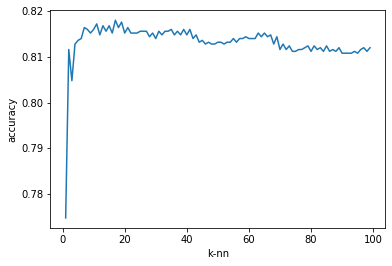

In [ ]:
figure = plt.figure()
ax = figure.add_subplot(111)
ax.plot(k_range, accuracy_list)
ax.set_xlabel('k-nn')
ax.set_ylabel('accuracy')
plt.show()

## 回帰

In [ ]:
# ---------------------------------
# データ等の準備
# ----------------------------------
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# ボストンの住宅価格
boston = load_boston()
train_x = pd.DataFrame(boston.data)
train_x.columns = boston.feature_names
train_y = pd.DataFrame(boston.target)

# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# 学習
knr = KNeighborsRegressor()
knr.fit(tr_x, tr_y)
va_pred = knr.predict(va_x)

mae = mean_absolute_error(va_y, va_pred)
rmse = np.sqrt(mean_squared_error(va_y, va_pred))

print('平均絶対誤差: ', mae)
print('二乗平均平方根誤差:', rmse)

平均絶対誤差:  4.273228346456693
二乗平均平方根誤差: 5.950096670954244


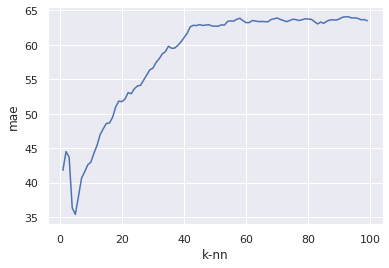

In [ ]:
# n_neighborsを増やした際の傾向を可視化
mae_list = []
sns.set()
k_range = range(1, 100)
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(tr_x, tr_y)
    va_pred = knn.predict(va_x)
    mae_list.append(mean_squared_error(va_y, va_pred))

figure = plt.figure()
ax = figure.add_subplot(111)
ax.plot(k_range, mae_list)
ax.set_xlabel('k-nn')
ax.set_ylabel('mae')
plt.show()

# ランダムフォレスト  
- GBDTと違い並列処理  
- レコードや特徴量をサンプリングして多様な決定木を作成してアンサンブルする  
- 分岐は回帰タスクでは二乗誤差、分類では時に不純度が最も減少するように行う  
決定木毎に元の個数と同じだけのレコードを復元抽出する**ブートストラップサンプリング**が行われる
  - 復元抽出されるレコードに対して1/3程度が抽出されないレコードとなる

## 分類

In [ ]:
# ---------------------------------
# データ等の準備
# ----------------------------------
# train_xは学習データ、train_yは目的変数、test_xはテストデータ
# pandasのDataFrame, Seriesで保持します。（numpyのarrayで保持することもあります）
# one-hot encodingされたものを読み込む

train = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/train_preprocessed_onehot.csv')
train_x = train.drop(['target'], axis=1)
train_y = train['target']
test_x = pd.read_csv('https://raw.githubusercontent.com/ghmagazine/kagglebook/master/input/sample-data/test_preprocessed_onehot.csv')

# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

# -----------------------------------
# ランダムフォレストの実装
# -----------------------------------
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=1234)
model.fit(tr_x, tr_y)
print("mean Accuracy", model.score(va_x, va_y))


score= 0.86


## 回帰

In [ ]:
# ---------------------------------
# データ等の準備
# ----------------------------------
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# ボストンの住宅価格
boston = load_boston()
train_x = pd.DataFrame(boston.data)
train_x.columns = boston.feature_names
train_y = pd.DataFrame(boston.target)

# 学習データを学習データとバリデーションデータに分ける
from sklearn.model_selection import KFold

kf = KFold(n_splits=4, shuffle=True, random_state=71)
tr_idx, va_idx = list(kf.split(train_x))[0]
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]


# -----------------------------------
# ランダムフォレストの実装
# -----------------------------------
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=10, max_depth=20)
# np.ravel() | 一次元化されたnumpy.ndarrayを返す
model.fit(tr_x, np.ravel(tr_y))

va_pred = model.predict(va_x)

mae = mean_absolute_error(va_y, va_pred)
rmse = np.sqrt(mean_squared_error(va_y, va_pred))

print('平均絶対誤差: ', mae)
print('二乗平均平方根誤差:', rmse)
# https://bellcurve.jp/statistics/course/9706.html
print("決定係数 coefficient of determination", model.score(va_x, va_y))

平均絶対誤差:  2.478110236220472
二乗平均平方根誤差: 3.4830290464741576
決定係数 coefficient of determination 0.8441599923808617


# FFM | Field-aware Factorization Machines
検討中